In [1]:
# Run the command below if necessary, for example with Google Colab
#!python3 -m pip install mxnet-cu110

In [2]:
# Global Libraries
import collections
import gluoncv as gcv
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import os
from sklearn import metrics

# MXNet ND-Arrays with Numpy notation
mx.npx.set_np()

# Local Libraries
import utils

# GPU mode
ctx = mx.gpu()

/home/andres/.local/lib/python3.8/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.8.0` and `torch==1.9.0+cu111` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [5]:
# Load Dataset: Dogs vs Cats
# https://www.kaggle.com/c/dogs-vs-cats
from importlib import reload
reload(utils)

# Change line below to the corresponding path
# where dogs-vs-cats.zip file has been downloaded
path = os.getcwd()

# Pre-processing the data, splitting training, validation and test set
# in 80% (20k samples), 10% (2500 samples), 10% (2500 samples)
# Uncomment the line below if this is the 1st execution
# It will yield wrong results if run several times
#utils.preprocess_kaggle_cats_vs_dogs(path, [0.8, 0.1, 0.1])

# Generate DataLoader with pre-processing for ImageNet
train_dataset, val_dataset, test_dataset = utils.generate_cats_vs_dogs_datasets(path, imageNet=False)
train_dataldr, _, test_dataldr = utils.generate_cats_vs_dogs_dataloaders(train_dataset, None, test_dataset, batch_size=256)

classes = ["Cats", "Dogs"]
classes_dict = utils.generate_class_dict_cats_vs_dogs_imagenet()

number_of_features = 224 * 224

In [7]:
# Collect labels for the test dataset
X_data = None
y_data = None

for X_batch, y_batch in test_dataldr:
    
    X_batch_gray = utils.rgb_to_gray(X_batch)    
    X_batch_gray = X_batch_gray.reshape(
        X_batch_gray.shape[0], number_of_features)
    y_batch = y_batch.asnumpy()

    if y_data is None:
        X_data = np.copy(X_batch_gray)
        y_data = np.copy(y_batch)
    else:
        X_data = np.concatenate((X_data, X_batch_gray), axis = 0)
        y_data = np.concatenate((y_data, y_batch), axis = 0)

OrderedDict([(0, 1250), (1, 1250)])


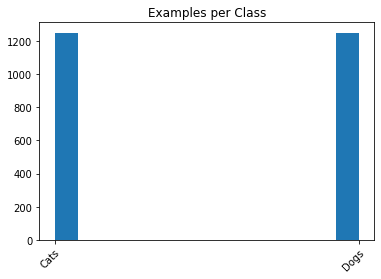

In [8]:
# Number of examples per class

labels_counter = collections.Counter(y_data)
print(collections.OrderedDict(sorted(labels_counter.items())))

ax = plt.subplot()
ax.hist(y_data, bins="auto")
plt.xticks(range(2))
ax.set_xticklabels(classes, rotation=45, rotation_mode="anchor", ha="right")
plt.title("Examples per Class")
plt.show()

Number of batches seen: 1


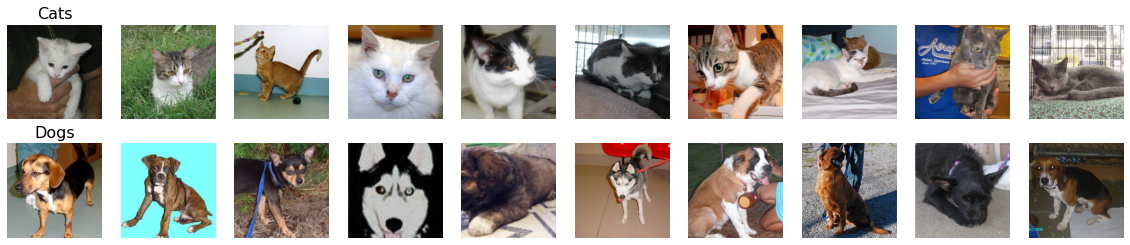

In [6]:
# Images in Grid Format

number_of_classes = len(classes)
number_of_images_per_class = 10

#fig, axes = plt.subplots(number_of_classes, number_of_images_per_class)#, figsize=(2, 20))
fig = plt.figure(figsize=(20, 4))

# Keep track of instances found
instances_per_class = {}
remaining_instances_to_be_found = set(range(number_of_classes))

# Traverse through the training set to find the 1st instances per class (number_of_images_per_class)
for iteration, (X_batch, y_batch) in enumerate(train_dataldr):    
    for X, y in zip(X_batch, y_batch):
        
        # Format inputs
        X = X.asnumpy()
        y = y.asnumpy().item()

        if y in instances_per_class and instances_per_class[y] == 10:
            if y in remaining_instances_to_be_found:
                remaining_instances_to_be_found.remove(y)
            continue
        
        if y not in instances_per_class:
            instances_per_class[y] = 0
            axes = fig.add_subplot(2, 10, y * 10 + 1)
            axes.set_title(classes[y], fontsize=16)
        else:
            axes = fig.add_subplot(2, 10, y * 10 + instances_per_class[y] + 1)

        axes.imshow(X)
        axes.axis('off')

        instances_per_class[y] += 1

    if not remaining_instances_to_be_found:
        # We are done
        break

print("Number of batches seen:", iteration + 1)

In [7]:
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

In [8]:
# PCA Calculation (2 components)
pca = PCA(n_components=2)

pca_df = pd.DataFrame(columns=["x", "y", "class"])

pca_result = pca.fit_transform(X_data)

new_df = pd.DataFrame({
    "x": pca_result[:, 0],
    "y": pca_result[:, 1],
    "class": y_data
    })

pca_df = pca_df.append(new_df, ignore_index=True)

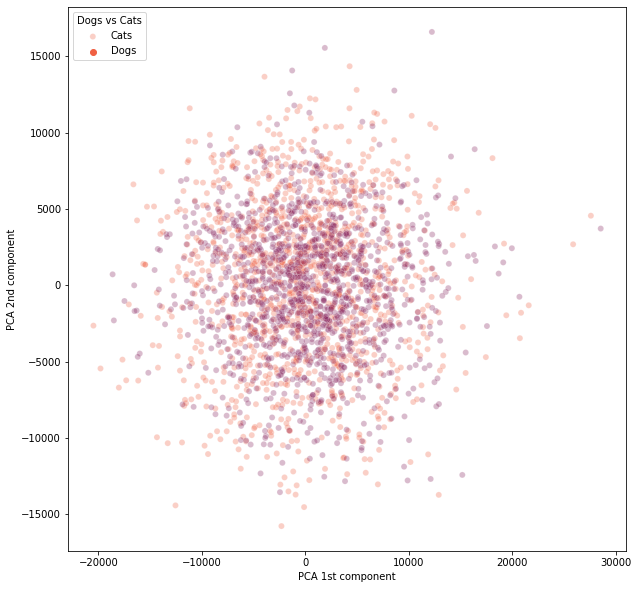

In [9]:
# PCA 2D Plot
plt.figure(figsize=(10, 10))

sns.scatterplot(
    data = pca_df,
    x = "x",
    y = "y",
    hue = "class",
    palette = sns.color_palette("rocket_r", 2),
    legend = "full",
    alpha = 0.3
)

# Modify Legend and Labels
plt.legend(classes, title = "Dogs vs Cats", loc="upper left")
plt.xlabel("PCA 1st component")
plt.ylabel("PCA 2nd component")

plt.show()

In [10]:
from sklearn.manifold import TSNE

In [12]:
pca = PCA(n_components=50)
pca_result = pca.fit_transform(X_data)

tsne = TSNE(n_components=2)
tsne_df = pd.DataFrame(columns=["x", "y", "class"])

tsne_result = tsne.fit_transform(pca_result)

new_df = pd.DataFrame({
    "x": tsne_result[:, 0],
    "y": tsne_result[:, 1],
    "class": y_data
    })
tsne_df = tsne_df.append(new_df, ignore_index=True)

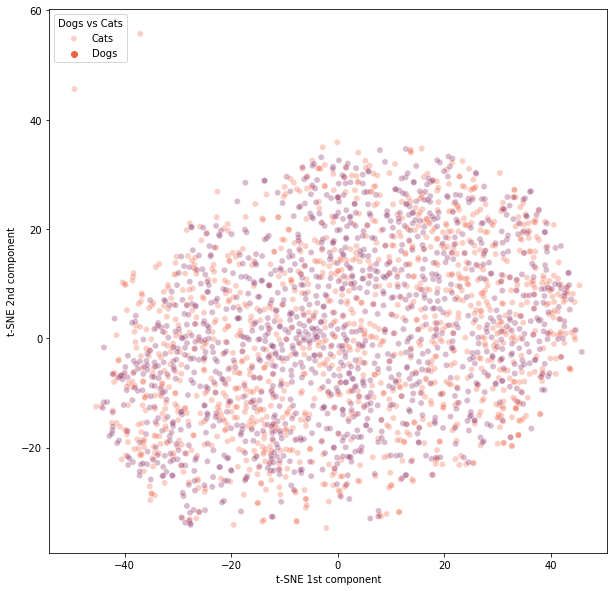

In [13]:
# t-SNE Plot
plt.figure(figsize=(10, 10))

sns.scatterplot(
    data = tsne_df,
    x = "x",
    y = "y",
    hue = "class",
    palette = sns.color_palette("rocket_r", 2),
    legend = "full",
    alpha = 0.3
)

# Modify Legend and Labels
plt.legend(classes, title = "Dogs vs Cats", loc="upper left")
plt.xlabel("t-SNE 1st component")
plt.ylabel("t-SNE 2nd component")

plt.show()

In [12]:
import umap

In [13]:
embedding = umap.UMAP(n_neighbors=5).fit_transform(X_data)

Text(0.5, 1.0, 'Dogs vs Cats Embeddings via UMAP')

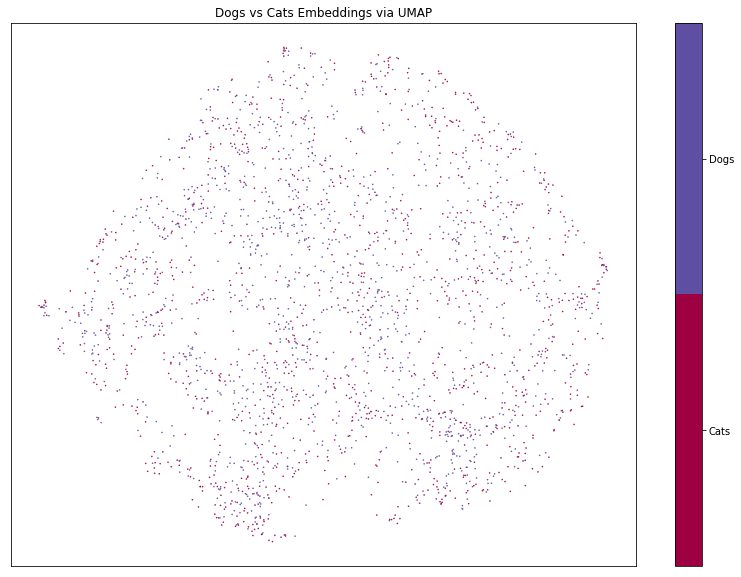

In [15]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.3, c=y_data, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(3)-0.5)
cbar.set_ticks(np.arange(2))
cbar.set_ticklabels(classes)
plt.title('Dogs vs Cats Embeddings via UMAP')

In [19]:
import model
reload(model)

alexnet = model.create_alexnet_network(num_classes = 2)
alexnet.collect_params().initialize(mx.init.MSRAPrelu(), ctx=ctx, force_reinit=True)

[00:38:10] ../src/base.cc:80: cuDNN lib mismatch: linked-against version 8101 != compiled-against version 8100.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.


In [43]:
reload(model)

# Define Loss Function (Binary, cats vs dogs)
#loss_fn = mx.gluon.loss.SigmoidBinaryCrossEntropyLoss()
loss_fn = mx.gluon.loss.SoftmaxCrossEntropyLoss()

# Epochs & Batch Size
# Optimal values: "adam", lr: 0.01, 10+ epochs, batch size 256
epochs = 5
batch_size = 128
alexnet.collect_params().initialize(mx.init.MSRAPrelu(), ctx=ctx, force_reinit=True)

# Define Optimizer and Hyper Parameters
trainer = mx.gluon.Trainer(alexnet.collect_params(), "sgd", {"learning_rate": 0.01})

training_loss, validation_loss, validation_acc, training_acc = model.training_loop(alexnet,
                                                                                   loss_fn,
                                                                                   trainer,
                                                                                   epochs,
                                                                                   batch_size,
                                                                                   train_dataset,
                                                                                   val_dataset,
                                                                                   ctx)

[20:28:10] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


E:    0, TrL: 0.725119, TrAcc: 0.563650, VL: 0.639778, VAcc: 0.651200 --- Updating saved model
E:    1, TrL: 0.645692, TrAcc: 0.614000, VL: 0.616874, VAcc: 0.683600 --- Updating saved model
E:    2, TrL: 0.614313, TrAcc: 0.653150, VL: 0.569561, VAcc: 0.720400 --- Updating saved model
E:    3, TrL: 0.570887, TrAcc: 0.691550, VL: 0.525167, VAcc: 0.738800 --- Updating saved model
E:    4, TrL: 0.541722, TrAcc: 0.715300, VL: 0.525339, VAcc: 0.755200 --- Updating saved model


In [20]:
alexnet.load_parameters(model.MODEL_FILE_NAME)

In [44]:
# Run testset through our network (AlexNet)
expected_outputs = []
class_outputs = []

acc = mx.metric.Accuracy()

for images, labels in test_dataldr:
    output = alexnet(images.as_in_context(ctx))

    class_output_imagenet = np.argmax(output, axis=1)
    class_output = class_output_imagenet
    
    acc.update(labels, class_output)
    
    expected_outputs += labels.tolist()
    class_outputs += class_output.asnumpy().tolist()

In [45]:
print(acc.get())

('accuracy', 0.7472)


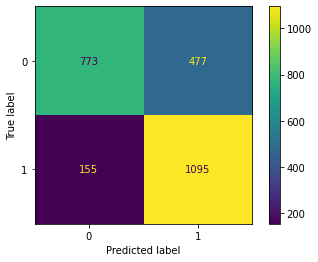

In [46]:
# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(expected_outputs, class_outputs)
cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_disp.plot()

In [24]:
# AlexNet from Model Zoo (This downloads v1d)
# Requires disabling NumPy Semantics
mx.npx.reset_np()

# By disabling np semantics, we also need to reload datasets
# Generate DataLoader with pre-processing for ImageNet
train_dataset_npx, val_dataset_npx, test_dataset_npx = utils.generate_cats_vs_dogs_datasets(path, imageNet=True)
_, _, test_dataldr_npx = utils.generate_cats_vs_dogs_dataloaders(None, None, test_dataset_npx, batch_size=32)

alexnet_npx = gcv.model_zoo.get_model("alexnet", pretrained=True, ctx=ctx)

In [25]:
# Run testset through our network (AlexNet)
expected_outputs = []
class_outputs = []

acc = mx.metric.Accuracy()

for images, labels in test_dataldr_npx:
    output = alexnet_npx(images.as_in_context(ctx))
    
    class_output_imagenet = np.argmax(output, axis=1)    
    class_output = mx.nd.array([classes_dict[idx] for idx in class_output_imagenet.asnumpy()])
    
    acc.update(labels, class_output)
    
    expected_outputs += labels.asnumpy().tolist()
    class_outputs += class_output.asnumpy().tolist()

[01:14:21] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


In [26]:
print(acc.get())

('accuracy', 0.7324)


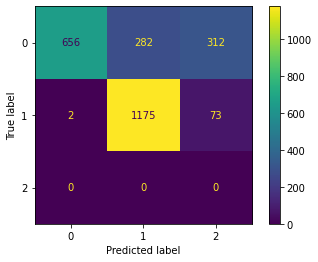

In [27]:
# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(expected_outputs, class_outputs)
cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_disp.plot()

In [28]:
# Back to NumPy Semantics
mx.npx.set_np()

# ResNet50 from Model Zoo (This downloads v1d)
resnet50 = gcv.model_zoo.get_model("resnet50_v1d", pretrained=True, ctx=ctx)

# Generate DataLoader with pre-processing for ImageNet
train_dataset, val_dataset, test_dataset = utils.generate_cats_vs_dogs_datasets(path, imageNet=True)
_, _, test_dataldr = utils.generate_cats_vs_dogs_dataloaders(None, None, test_dataset, batch_size=32)

In [29]:
# Run testset through our network (ResNet50)
expected_outputs = []
class_outputs = []

acc = mx.metric.Accuracy()
f1  = mx.metric.F1()

for images, labels in test_dataldr:
    output = resnet50(images.as_in_context(ctx))
    
    class_output_imagenet = np.argmax(output, axis=1)
    class_output = mx.nd.array([classes_dict[idx] for idx in class_output_imagenet.asnumpy()])
    
    acc.update(labels, class_output)
    
    expected_outputs += labels.tolist()
    class_outputs += class_output.asnumpy().tolist()

[01:16:06] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


In [30]:
print(acc.get())

('accuracy', 0.9148)


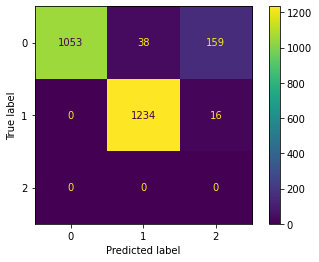

In [31]:
# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(expected_outputs, class_outputs)
cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_disp.plot()